#  2_DNN_Model.ipynb – Building and Training the Multi Modal DNN

In this notebook, I will build a multi modal DNN that combines structured tabular data and loan description text to predict loan approval outcomes.

- The **tabular features** (like income, loan amount, credit score) are preprocessed using scaling and one-hot encoding.
- The **text input** (purpose + title) is tokenized and passed through a **frozen BERT encoder** to capture semantic meaning.
- I merge the tabular and text representations and feed them through dense layers to make the final prediction.

Training is done using binary cross-entropy with early stopping. I track performance on both validation and test sets using accuracy, precision, recall, F1-score, AUC, and more along with helpful visualizations and a confusion matrix.

At the end, the trained model is saved for reuse in later notebooks.

# Step 1: Load Sampled Data and Prepare Inputs

In this step, I’m loading the preprocessed and balanced dataset I prepared. I’ll separate the tabular features, the combined text field (for BERT), and the target label. Then I’ll split everything into training, validation, and test sets.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
data_path = '/content/drive/MyDrive/LoanApprovalProject/Data/loan_data_sampled.csv'
df = pd.read_csv(data_path)

print("Shape:", df.shape)
df.head()


Mounted at /content/drive
Shape: (20000, 14)


,loan_amnt,term,int_rate,grade,emp_title,home_ownership,annual_inc,verification_status,dti,open_acc,revol_util,fico_range_high,loan_status,text
0,9875.0,36 months,12.74,C,Teacher,MORTGAGE,65000.0,Source Verified,34.60,10.0,37.1,724.0,0,home_improvement - Home improvement
1,24000.0,60 months,18.25,D,Supervisor/SPD,MORTGAGE,70000.0,Not Verified,33.14,18.0,32.1,729.0,0,debt_consolidation - Debt consolidation
2,14075.0,36 months,16.99,D,ramp agent,RENT,32000.0,Not Verified,21.79,8.0,29.2,709.0,0,debt_consolidation - Debt consolidation
3,4800.0,36 months,13.99,C,Technician,RENT,40000.0,Source Verified,18.54,5.0,90.0,669.0,0,debt_consolidation - Debt consolidation
4,12000.0,36 months,9.17,B,Partner,MORTGAGE,300000.0,Source Verified,7.03,13.0,40.6,664.0,0,debt_consolidation - Debt consolidation


# Step 2: Split Features and Target for Multi-Modal Model

Now I’ll separate the tabular inputs, the BERT-ready text field, and the target label. Then I’ll split everything into training, validation, and test sets using stratified sampling to preserve class balance.


In [2]:
from sklearn.model_selection import train_test_split

# Separate features
X_tabular = df.drop(['loan_status', 'text'], axis=1)
X_text = df['text']
y = df['loan_status']

# Split into train, val, test (60/20/20 split)
X_tab_train, X_tab_temp, X_text_train, X_text_temp, y_train, y_temp = train_test_split(
    X_tabular, X_text, y, test_size=0.4, stratify=y, random_state=42
)

X_tab_val, X_tab_test, X_text_val, X_text_test, y_val, y_test = train_test_split(
    X_tab_temp, X_text_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_tab_train.shape, "Val:", X_tab_val.shape, "Test:", X_tab_test.shape)


Train: (12000, 12) Val: (4000, 12) Test: (4000, 12)


# Step 3: Preprocess Tabular Data

In this step, I’ll prepare the tabular features for the model by applying one-hot encoding to categorical variables and scaling the numerical ones. I’ll use `ColumnTransformer` to organize both transformations into one step.


In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

categorical_cols = ['term', 'grade', 'emp_title', 'home_ownership', 'verification_status']
numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'revol_util', 'fico_range_high']

# processing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

tabular_transformer = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Fit-transform training data
X_tab_train_processed = tabular_transformer.fit_transform(X_tab_train)

# Save transformer for SHAP or reuse
joblib.dump(tabular_transformer, '/content/drive/MyDrive/LoanApprovalProject/Code/dnn_preprocessor.joblib')
print(" Preprocessor saved to /Code/dnn_preprocessor.joblib")


# Transform val/test
X_tab_val_processed = tabular_transformer.transform(X_tab_val)
X_tab_test_processed = tabular_transformer.transform(X_tab_test)

print("Train (tabular):", X_tab_train_processed.shape)


 Preprocessor saved to /Code/dnn_preprocessor.joblib
Train (tabular): (12000, 6429)


>  **Note**:  
This tabular preprocessor is saved and will be reused later during SHAP explainability and in the comparison notebook to ensure consistent feature transformation.

# Step 4: Tokenize Text for BERT

Now I’ll use Hugging Face’s BERT tokenizer to tokenize the `text` inputs. This will convert each sentence into input IDs and attention masks, padded to a fixed length (64 tokens). These will be passed to the BERT encoder in the model.


In [4]:
!pip install -q transformers

from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Helper function to tokenize text
def tokenize_texts(texts, max_len=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='np'
    )

# Tokenize each split
X_text_train_tok = tokenize_texts(X_text_train)
X_text_val_tok   = tokenize_texts(X_text_val)
X_text_test_tok  = tokenize_texts(X_text_test)

# Check shape of token IDs
print("Tokenized input IDs (train):", X_text_train_tok['input_ids'].shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenized input IDs (train): (12000, 64)


# Step 5: Build the Multi-Modal DNN Model

This model has two input branches: one for tabular data and one for text (BERT). I’ll concatenate the outputs of both branches and pass them through a final dense layer for binary classification.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Lambda
from tensorflow.keras.models import Model
from transformers import TFBertModel

# Tabular input branch
tab_input = Input(shape=(X_tab_train_processed.shape[1],), name='tabular_input')
x_tab = Dense(64, activation='relu')(tab_input)
x_tab = Dropout(0.3)(x_tab)
x_tab = Dense(32, activation='relu')(x_tab)

# Text input branch (BERT)
text_input_ids = Input(shape=(64,), dtype=tf.int32, name='input_ids')
text_attention = Input(shape=(64,), dtype=tf.int32, name='attention_mask')

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = False  # Freeze BERT

# Lambda wrapper to integrate BERT into Keras functional model
def get_bert_output(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.pooler_output

x_text = Lambda(get_bert_output, output_shape=(768,))([text_input_ids, text_attention])

# Combining both branches
combined = Concatenate()([x_tab, x_text])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# final model
model = Model(inputs=[tab_input, text_input_ids, text_attention], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 6429)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    411,520 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 800)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     51,264 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,929 (1.77 MB)

 Trainable params: 464,929 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

###  DNN Architecture Summary

The model has two input branches:

- **Tabular Branch**:  
  `Input → Dense(64, relu) → Dropout(0.3) → Dense(32, relu)`

- **Text Branch (BERT)**:  
  `Input (IDs + Attention) → Frozen BERT → 768-dim output`

- **Fusion & Output**:  
  `Concatenate → Dense(64, relu) → Dropout(0.3) → Dense(1, sigmoid)`

# Step 6: Train the Model

Now I’ll train the multi-modal model using binary cross-entropy loss and early stopping. The model will use the tabular features and tokenized text inputs together, and evaluate on the validation set.


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Prepare input dictionaries for training
train_inputs = {
    'tabular_input': X_tab_train_processed,
    'input_ids': X_text_train_tok['input_ids'],
    'attention_mask': X_text_train_tok['attention_mask']
}

val_inputs = {
    'tabular_input': X_tab_val_processed,
    'input_ids': X_text_val_tok['input_ids'],
    'attention_mask': X_text_val_tok['attention_mask']
}

# Callback for early stopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# Training
history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - accuracy: 0.5704 - loss: 0.7010 - val_accuracy: 0.6655 - val_loss: 0.6220
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - accuracy: 0.6633 - loss: 0.6250 - val_accuracy: 0.6593 - val_loss: 0.6251
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - accuracy: 0.6958 - loss: 0.6014 - val_accuracy: 0.6582 - val_loss: 0.6180
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 143ms/step - accuracy: 0.7607 - loss: 0.5157 - val_accuracy: 0.6413 - val_loss: 0.6800
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 143ms/step - accuracy: 0.8294 - loss: 0.4016 - val_accuracy: 0.6365 - val_loss: 0.7055
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 143ms/step - accuracy: 0.8490 - loss: 0.3625 - val_accuracy: 0.6400 - val_loss: 0.7413


###  Training Observations

- The model trained for 6 epochs before early stopping was triggered.
- Validation accuracy plateaued around **64%**, slightly behind training accuracy.
- Training accuracy steadily improved, reaching **~85% by epoch 6**.
- Overfitting began to appear from epoch 4 onward (gap between train/val accuracy).
- Overall, the model trained stably — the next step is to evaluate on the test set.

>  **Let's visualize training progress**  
We’ll now plot training and validation accuracy/loss across epochs to understand how the model learned over time — and check for overfitting.

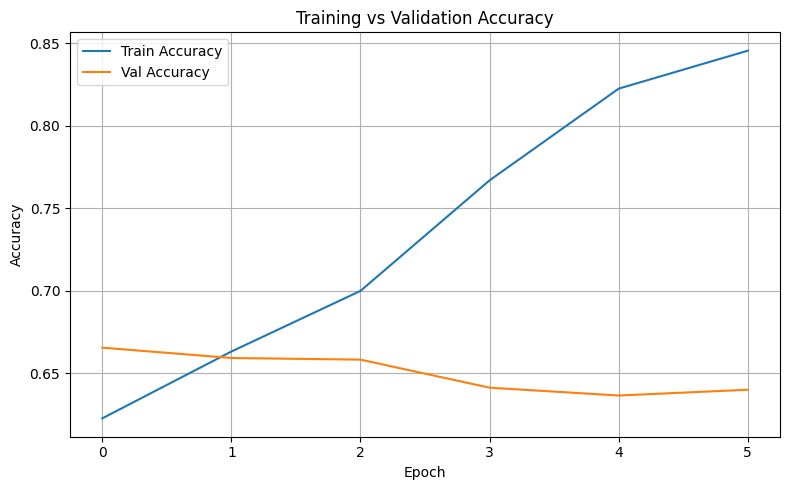

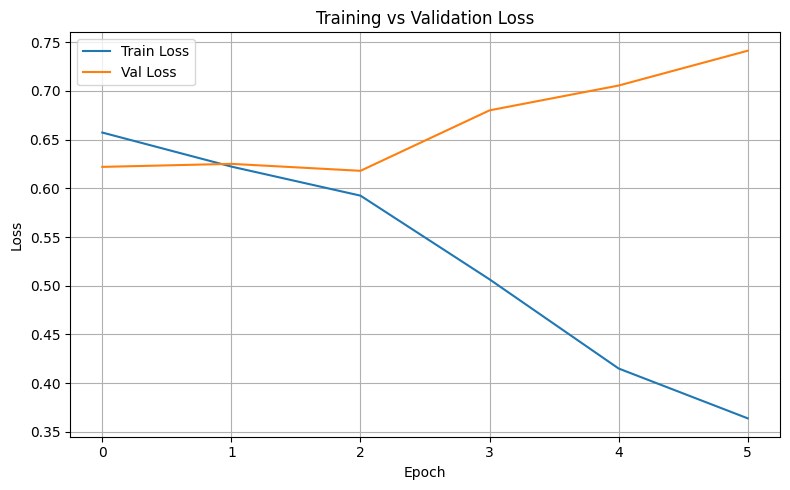

In [7]:
import matplotlib.pyplot as plt
import os

fig_dir = '/content/drive/MyDrive/LoanApprovalProject/Figures'
os.makedirs(fig_dir, exist_ok=True)

# accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{fig_dir}/dnn_train_val_accuracy.png')
plt.show()

# loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{fig_dir}/dnn_train_val_loss.png')
plt.show()


# Step 7: Evaluate on the Test Set

Now I’ll evaluate the trained model on the test set using standard classification metrics. This includes accuracy, precision, recall, F1-score, and ROC-AUC. I’ll also generate a confusion matrix and ROC curve for visual inspection.


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns

# Prepare test inputs
test_inputs = {
    'tabular_input': X_tab_test_processed,
    'input_ids': X_text_test_tok['input_ids'],
    'attention_mask': X_text_test_tok['attention_mask']
}

# Predict probabilities
y_probs = model.predict(test_inputs)
y_pred = (y_probs > 0.5).astype(int)

# Metrics
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))


125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 247ms/step
              precision    recall  f1-score   support

           0       0.62      0.74      0.68      2000
           1       0.68      0.54      0.60      2000

    accuracy                           0.64      4000
   macro avg       0.65      0.64      0.64      4000
weighted avg       0.65      0.64      0.64      4000

ROC AUC: 0.6960575


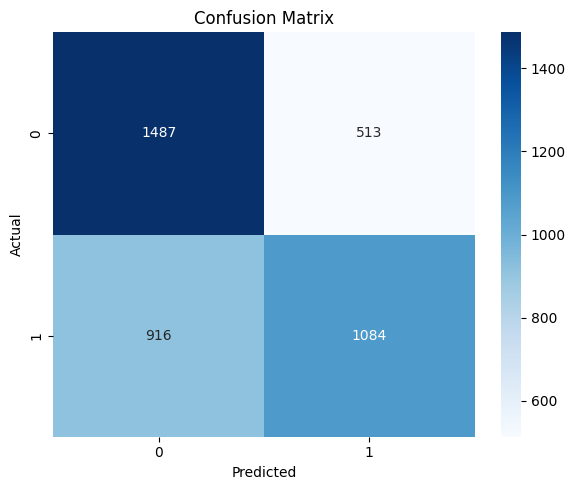

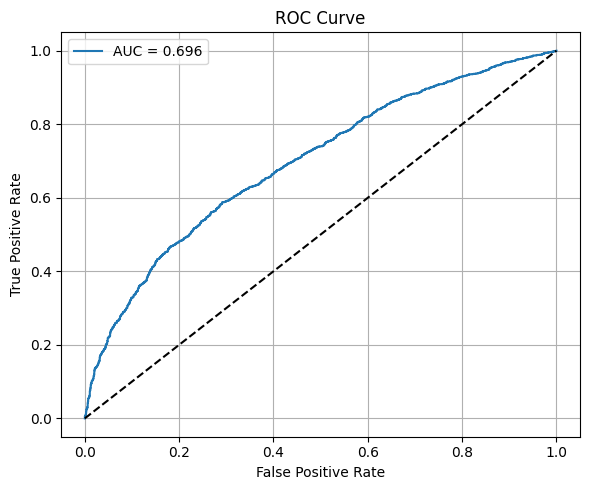

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f'{fig_dir}/dnn_confusion_matrix.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_probs):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{fig_dir}/dnn_roc_curve.png')
plt.show()


###  Evaluation Observations

- **Test Accuracy**: 64% — similar to validation performance.
- **Precision/Recall**:  
  - Class 0 (loan rejected): Higher recall (0.74), lower precision (0.62)  
  - Class 1 (loan approved): Higher precision (0.68), lower recall (0.54)
- **ROC AUC**: 0.696 — indicating moderate discriminative ability.
- **Confusion Matrix Insight**: More false negatives than false positives, meaning the model tends to reject loans that should be approved — an important consideration for risk calibration.
- Overall, performance is acceptable for a baseline DNN. Further comparison with the CNN model will follow.

#  Model Saving
 This cell saves the trained model to a `.h5` file for reuse in future sessions.

In [10]:
model.save('/content/drive/MyDrive/LoanApprovalProject/Code/dnn_model.h5')
print(" Model saved.")


 Model saved.
